# Планирование эксперемента, непрерывные переменные

## Подбор выборки для T-test (подбор значения)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Допустим человек на сайте в среднем проводит 15 минут и мы хотим сделать какое-то улучшение, чтобы человек проводит в среднем 17 минут.

<AxesSubplot:>

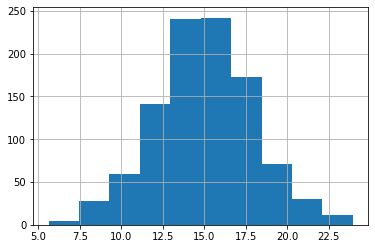

In [4]:
pd.Series(np.random.normal(15,3,size=1000)).hist()

<AxesSubplot:>

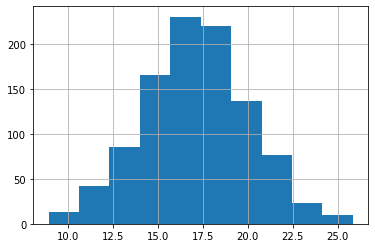

In [5]:
pd.Series(np.random.normal(17,3,size=1000)).hist()

In [6]:
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

Предполагаем, что дисперсии не равны.

In [7]:
baseline = 15
mde = 2
result = []
n = 10000
sample_size = 36
for _ in tqdm(range(n)):
  a = np.random.normal(baseline,3,size=sample_size)
  b = np.random.normal(baseline + mde,3,size=sample_size)
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

In [8]:
t = pd.Series(result)

In [9]:
(t < 0.05).mean()

0.7945

## Проверим как распределено выборочное среднее

In [11]:
p = pd.Series([np.random.normal(15,3,size=50).mean() for _ in range(1000)])

<AxesSubplot:>

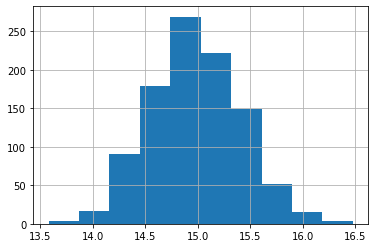

In [12]:
p.hist()

Построим QQ-plot.

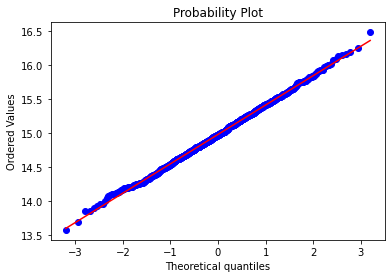

In [14]:
# проверим на нормальность
import pylab 
import scipy.stats as stats
   
stats.probplot(p, dist="norm", plot=pylab)
pylab.show()

## Проверим как распределено p-val при верной нулевой гипотезе.

In [15]:
baseline = 15
mde = 2
result = []
n = 10000
sample_size = 50
for _ in tqdm(range(n)):
  a = np.random.normal(baseline,3,size=sample_size)
  b = np.random.normal(baseline,3,size=sample_size)
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

In [16]:
t = pd.Series(result)

<AxesSubplot:>

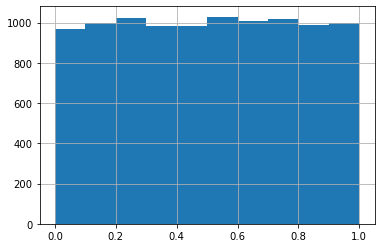

In [17]:
t.hist()

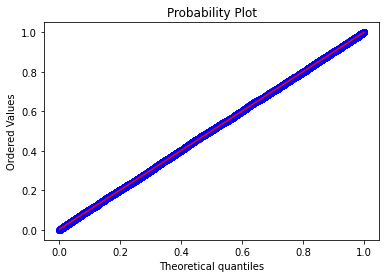

In [18]:
# равномерное распределение
stats.probplot(t, dist="uniform", plot=pylab)
pylab.show()

In [19]:
(t < 0.05).mean()

0.0467

## Критерии применения t-test

При каких условиях иожно применять t-test:
1) выборочное среднее распределено нормально (bootstrap + qq)

2) p-value для выборок из одного распределения имеет равномерное распределение (bootstrap + qq)

3) теоретический false positive == практическому false positive

## Определим размер выборки математически

In [21]:
import statsmodels.stats.api as sms

In [22]:
sample = pd.Series(np.random.normal(15,3,size=1000))

In [27]:
s = sample.std()
s

3.003975116505479

In [28]:
es = (17 - 15)/ s

In [29]:
sms.TTestIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1)

36.39928351865144

совпало с обычным подбором значений

### Протестируем t-test на логнормальном распределении (ненормальное распределение)

In [30]:
a = np.random.lognormal(mean=5, sigma=2, size=(100000,))
b = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))

In [32]:
t = pd.Series([np.random.lognormal(mean=5, sigma=2, size=(100000,)).mean() for _ in tqdm(range(1000))])

<AxesSubplot:>

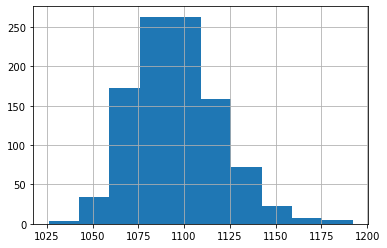

In [33]:
t.hist()

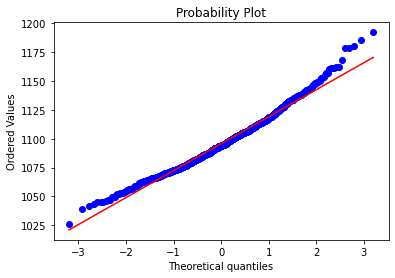

In [34]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

Распределение не нормальное

Проведем A/A test

In [35]:
result = []
n = 1000
for _ in tqdm(range(n)):
  a = np.random.lognormal(mean=5, sigma=2, size=(100000,))
  b = np.random.lognormal(mean=5, sigma=2, size=(100000,))
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

In [36]:
t = pd.Series(result)

<AxesSubplot:>

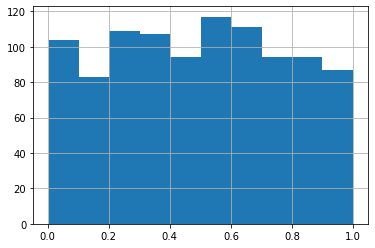

In [37]:
t.hist()

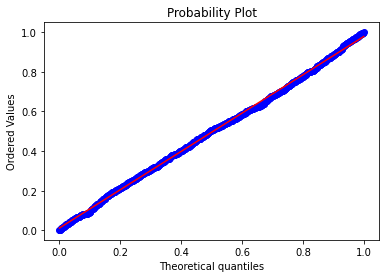

In [38]:
stats.probplot(t, dist="uniform", plot=pylab)
pylab.show()

In [39]:
(t < 0.05).mean()

0.041

In [40]:
result = []
n = 1000
for _ in tqdm(range(n)):
  a = np.random.lognormal(mean=5, sigma=2, size=(100000,))
  b = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

In [41]:
t = pd.Series(result)

In [42]:
(t < 0.05).mean()

0.29

Мощность не достигается, значит надо увеличивать выборки

### Рассчитаем размер выборки с помощью математики

оценка на bootstrap

In [43]:
a_mean_bs = pd.Series([np.random.lognormal(mean=5, sigma=2, size=(100000,)).mean() for _ in tqdm(range(1000))]).mean()

In [44]:
b_mean_bs = pd.Series([np.random.lognormal(mean=5.04, sigma=2, size=(100000,)).mean() for _ in tqdm(range(1000))]).mean()

In [45]:
a_mean_bs

1097.0373855391067

In [46]:
b_mean_bs

1141.651604067164

математическая оценка

In [48]:
a_mean_math = np.exp(5 + (2**2)/2)
a_mean_math

1096.6331584284585

In [49]:
b_mean_math = np.exp(5.04 + (2**2)/2)
b_mean_math

1141.387606628968

In [54]:
a.std()

8290.597852317364

In [51]:
es = (b_mean_math - a_mean_math)/ a.std()
es

0.005398217233272237

In [55]:
# необходимое количество наблюдений
round(sms.TTestIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))

538687

In [56]:
t = pd.Series([np.random.lognormal(mean=5, sigma=2, size=(538687,)).mean() for _ in tqdm(range(1000))])

<AxesSubplot:>

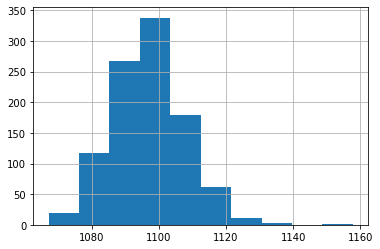

In [57]:
t.hist()

In [58]:
result = []
n = 1000
for _ in tqdm(range(n)):
  a = np.random.lognormal(mean=5, sigma=2, size=(538687,))
  b = np.random.lognormal(mean=5.04, sigma=2, size=(538687,))
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

In [61]:
t = pd.Series(result)

In [62]:
(t < 0.05).mean()

0.825

## Логарифмирование

In [66]:
result = []
n = 1000
for _ in tqdm(range(n)):
  a = np.log(np.random.lognormal(mean=5, sigma=2, size=(100000,)))
  b = np.log(np.random.lognormal(mean=5.04, sigma=2, size=(100000,)))
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

In [67]:
t = pd.Series(result)

In [68]:
(t < 0.05).mean()

0.992

В логарифмировании получился запас мощности, вычислим выборку нужного размера. Используем метод понижения дисперсии.

In [70]:
a = np.random.lognormal(mean=5, sigma=2, size=(100000,))
es = (np.log(b_mean_math) - np.log(a_mean_math))/ np.log(a).std()
es

0.020020679380792435

In [72]:
round(sms.TTestIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))

39164

In [73]:
result = []
n = 1000
for _ in tqdm(range(n)):
  a = np.log(np.random.lognormal(mean=5, sigma=2, size=(39164,)))
  b = np.log(np.random.lognormal(mean=5.04, sigma=2, size=(39164,)))
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

In [85]:
t = pd.Series(result)

In [86]:
(t < 0.05).mean()

0.789

# Подбор распределения под определенные данные

In [91]:
df = pd.read_csv(r'C:\Users\Lily_B\Documents\аналитика на python\Mall_Customers.csv', sep=',')
df

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [92]:
df['Annual Income (k$)'].mean()

60.56

<AxesSubplot:>

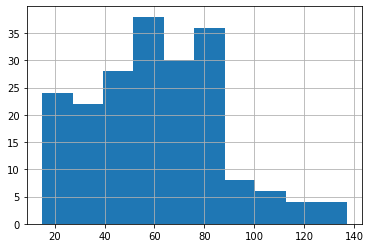

In [94]:
# распределение не нормальное
df['Annual Income (k$)'].hist()

Используем т-тест и посмотрим, будет ли распределение нормальным.

<AxesSubplot:>

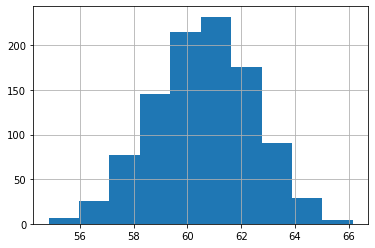

In [96]:
pd.Series([df['Annual Income (k$)'].sample(200,replace=True).mean() for _ in range(1000)]).hist()

Допустим, мы хотим, чтобы средний доход увеличился на 20к. Мы дали рекламу нашего бизнеса и смотрим, пришли ли к нам новые клиенты с более высоким доходом или нет.

In [100]:
es = (80 - 60) / df['Annual Income (k$)'].std()
es

0.7614777204048587

In [98]:
round(sms.TTestIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))

28

Теперь нужно проверить, правда ли это. Подберем распределение (rithon fit data to distribution)

  1 / 101: ksone
  2 / 101: kstwo
  3 / 101: kstwobign
  4 / 101: norm
  5 / 101: alpha
  6 / 101: anglit
  7 / 101: arcsine
  8 / 101: beta
  9 / 101: betaprime
 10 / 101: bradford
 11 / 101: burr
 12 / 101: burr12
 13 / 101: fisk
 14 / 101: cauchy
 15 / 101: chi
 16 / 101: chi2
 17 / 101: cosine
 18 / 101: dgamma
 19 / 101: dweibull
 20 / 101: expon
 21 / 101: exponnorm
 22 / 101: exponweib
 23 / 101: exponpow
 24 / 101: fatiguelife
 25 / 101: foldcauchy
 26 / 101: f
 27 / 101: foldnorm
 28 / 101: weibull_min
 29 / 101: weibull_max
 30 / 101: frechet_r
 31 / 101: frechet_l
 32 / 101: genlogistic
 33 / 101: genpareto
 34 / 101: genexpon
 35 / 101: genextreme
 36 / 101: gamma
 37 / 101: erlang
 38 / 101: gengamma
 39 / 101: genhalflogistic
 40 / 101: gompertz
 41 / 101: gumbel_r
 42 / 101: gumbel_l
 43 / 101: halfcauchy
 44 / 101: halflogistic
 45 / 101: halfnorm
 46 / 101: hypsecant
 47 / 101: gausshyper
 48 / 101: invgamma
 49 / 101: invgauss
 50 / 101: geninvgauss
 51 / 101: norminv

Text(0, 0.5, 'Frequency')

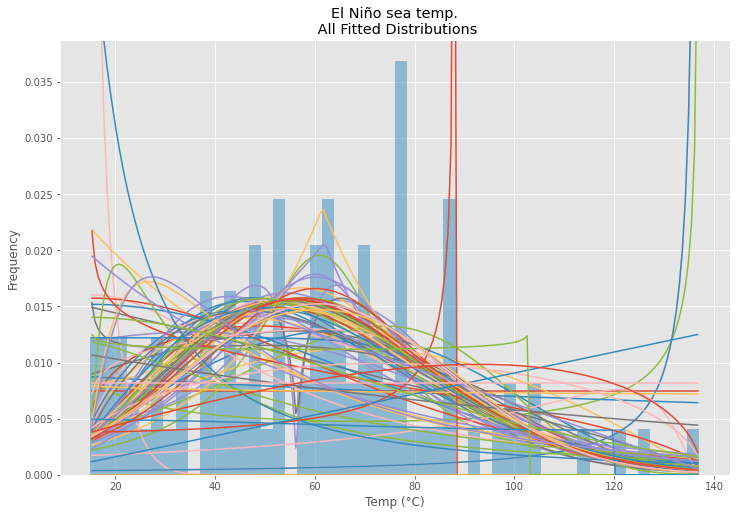

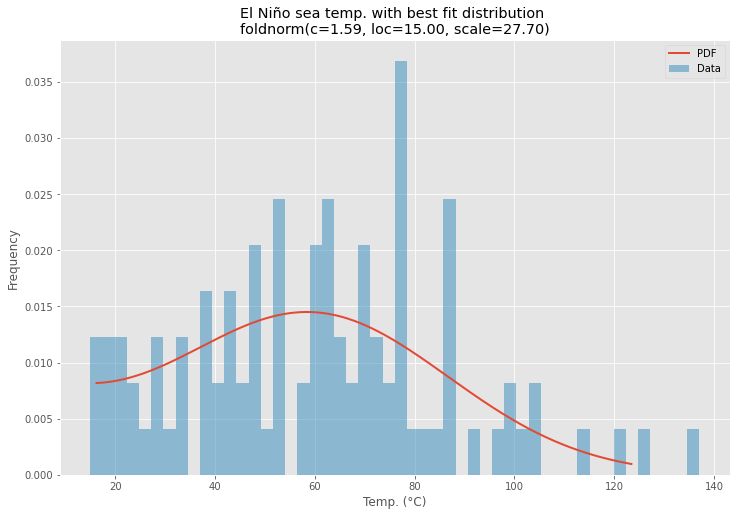

In [103]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = df['Annual Income (k$)']

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [105]:
pd.DataFrame(best_distibutions)

,0,1,2
0,<scipy.stats._continuous_distns.foldnorm_gen o...,"(1.5882739213012003, 14.999999996200923, 27.69...",4.220687e-02
1,<scipy.stats._continuous_distns.burr_gen objec...,"(7.500314764369716, 0.27209346187410244, -0.34...",4.241595e-02
2,<scipy.stats._continuous_distns.mielke_gen obj...,"(1.132924208855008, 7.3824870360288, 14.819937...",4.241633e-02
3,<scipy.stats._continuous_distns.gompertz_gen o...,"(0.37277957392680455, 14.999999999958362, 41.6...",4.247664e-02
4,<scipy.stats._continuous_distns.dweibull_gen o...,"(1.3618792152419525, 56.403900330041466, 23.35...",4.256603e-02
...,...,...,...
94,<scipy.stats._continuous_distns.weibull_max_ge...,"(0.18470492339036218, 137.00000000000003, 1.68...",1.072029e-01
95,<scipy.stats._continuous_distns.frechet_l_gen ...,"(0.18470492339036218, 137.00000000000003, 1.68...",1.072029e-01
96,<scipy.stats._continuous_distns.chi_gen object...,"(0.10395847298186744, 14.999999999999998, 6.89...",1.192571e-01
97,<scipy.stats._continuous_distns.vonmises_gen o...,"(1.1707375314549222, 68.27981350774687, 1.1653...",4.675603e+62


Посмотрим какое распределение дало наименьшую ошибку, где 2 - ошибка.

In [104]:
t = pd.DataFrame(best_distibutions).sort_values(2)

In [106]:
t[0][0]

Наше распредиление это - foldnorm_gen!

Параметры распределения:

In [107]:
t[1][0]

(1.5882739213012003, 14.999999996200923, 27.697222971318567)

# Подбор выборки для Манна-Уитни (bootstrap)

In [118]:
from scipy.stats import mannwhitneyu

In [119]:
result = []
n = 100
for _ in tqdm(range(n)):
  a = np.log(np.random.lognormal(mean=5, sigma=2, size=(42000,)))
  b = np.log(np.random.lognormal(mean=5.04, sigma=2, size=(42000,)))
  _, pval = mannwhitneyu(a,b,alternative='two-sided')
  result.append(pval)

In [120]:
t = pd.Series(result)

In [121]:
(t < 0.05).mean()

0.91

Проведем A/A тест.

In [122]:
result = []
n = 100
for _ in tqdm(range(n)):
  a = np.log(np.random.lognormal(mean=5, sigma=2, size=(30000,)))
  b = np.log(np.random.lognormal(mean=5, sigma=2, size=(30000,)))
  _, pval = mannwhitneyu(a,b)
  result.append(pval)

In [123]:
t = pd.Series(result)

Построим QQ график.

In [124]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

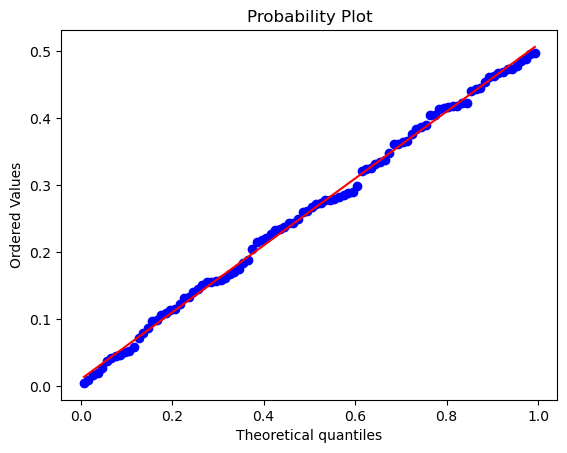

In [125]:
stats.probplot(t, dist="uniform", plot=pylab)
pylab.show()

In [126]:
(t < 0.05).mean()

0.09

Большая ошибка первого рода. Увеличим размер выборки.

In [127]:
result = []
n = 1000
for _ in tqdm(range(n)):
  a = np.log(np.random.lognormal(mean=5, sigma=2, size=(100000,)))
  b = np.log(np.random.lognormal(mean=5, sigma=2, size=(100000,)))
  _, pval = mannwhitneyu(a,b,alternative='two-sided')
  result.append(pval)

In [128]:
t = pd.Series(result)

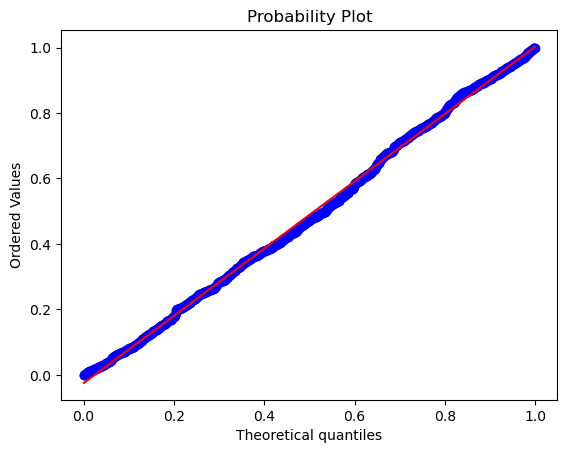

In [129]:
stats.probplot(t, dist="uniform", plot=pylab)
pylab.show()

In [130]:
(t < 0.05).mean()

0.062

p-val в 6% случаем < 0.05

<AxesSubplot:>

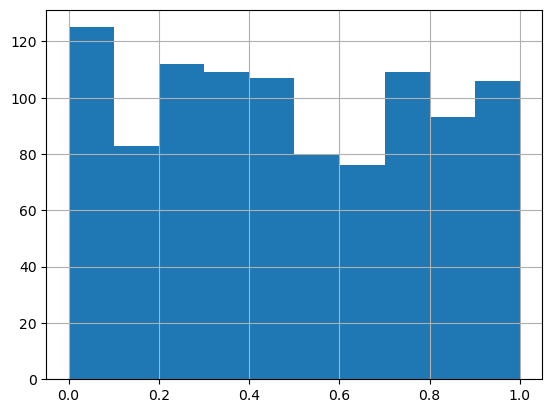

In [131]:
t.hist()